In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Phase 1: Think Simple 

## Import Data 

In [2]:
df = pd.read_csv("data/spaceship-titanic/train.csv", index_col="PassengerId")
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Nomenklatur

PassengerId - Id unik untuk setiap penumpang. Setiap Id memiliki bentuk gggg_pp di mana gggg menunjukkan grup yang ditumpangi penumpang dan pp adalah nomor penumpang di dalam grup tersebut. Orang-orang dalam satu grup sering kali merupakan anggota keluarga, tetapi tidak selalu..

HomePlanet - Planet tempat keberangkatan penumpang, biasanya merupakan planet tempat tinggal permanen mereka.

CryoSleep - menunjukkan apakah penumpang memilih untuk mati suri selama perjalanan. Penumpang yang berada dalam kondisi CryoSleep akan dikurung di dalam kabin.

Cabin - Nomor kabin tempat penumpang menginap. Berupa dek/nomor/sisi, di mana sisi dapat berupa P untuk Port atau S untuk Starboard.

Destination - Planet yang akan dituju oleh penumpang.

Age - Usia penumpang.

VIP - Apakah penumpang telah membayar layanan VIP khusus selama perjalanan.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Jumlah yang ditagihkan kepada penumpang di setiap fasilitas mewah di Kapal Antariksa Titanic.

Name - Nama depan dan belakang penumpang.

Transported - Apakah penumpang tersebut diangkut ke dimensi lain. Ini adalah target, kolom yang ingin Anda prediksi.

In [3]:
df.shape

(8693, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [5]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


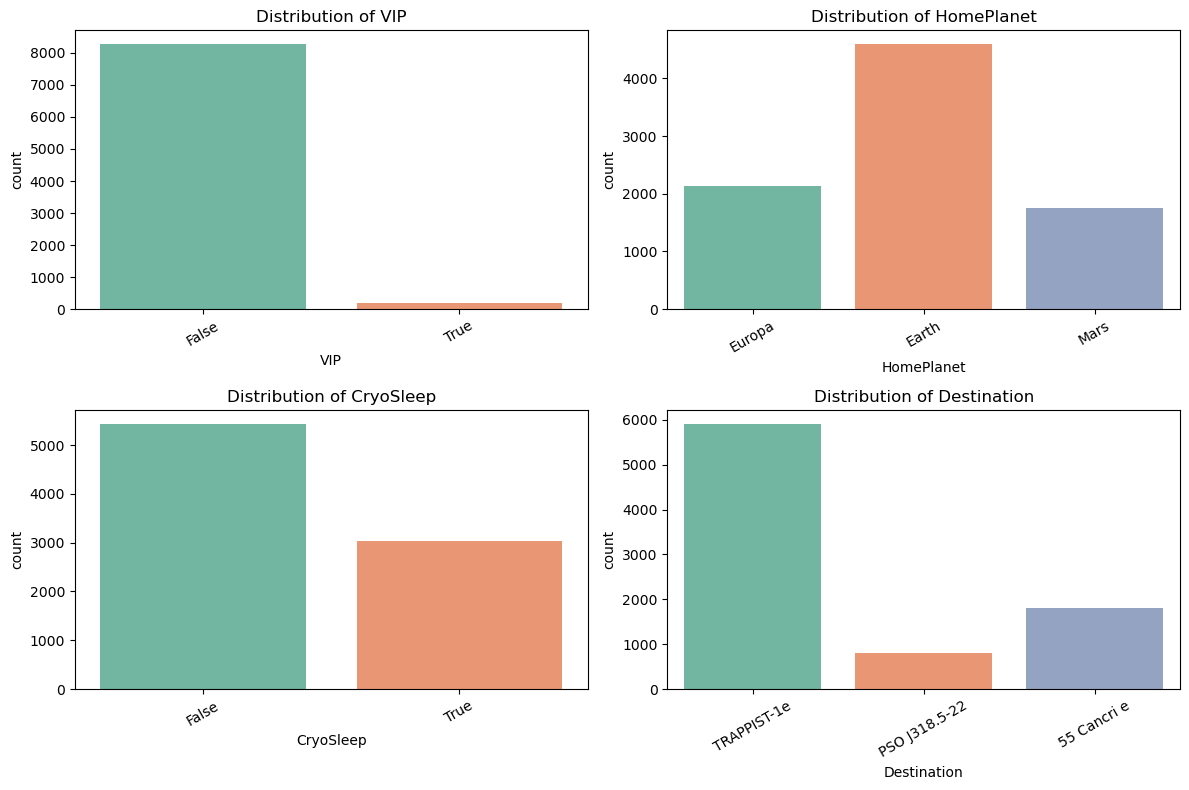

In [6]:
# 1. Bar Chart untuk kolom kategorikal
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
categorical_cols = ['VIP', 'HomePlanet', 'CryoSleep', 'Destination']

for ax, col in zip(axes.flatten(), categorical_cols):
    sns.countplot(x=df[col], ax=ax, palette='Set2')
    ax.set_title(f'Distribution of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.tight_layout()
plt.show()

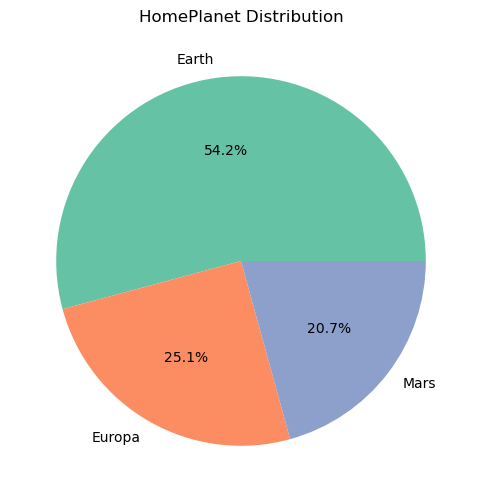

In [7]:
# 2. Pie Chart untuk kategori HomePlanet
plt.figure(figsize=(6, 6))
df['HomePlanet'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title("HomePlanet Distribution")
plt.ylabel('')
plt.show()

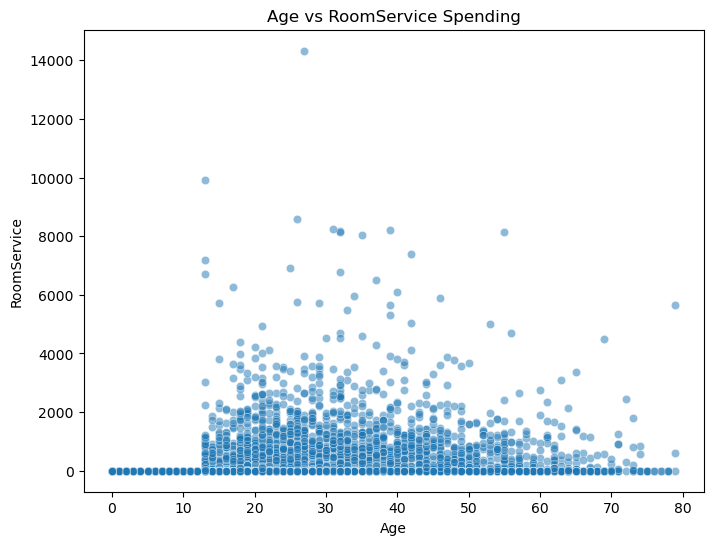

In [8]:
# 3. Scatter Plot (Age vs RoomService)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Age'], y=df['RoomService'], alpha=0.5)
plt.title("Age vs RoomService Spending")
plt.xlabel("Age")
plt.ylabel("RoomService")
plt.show()

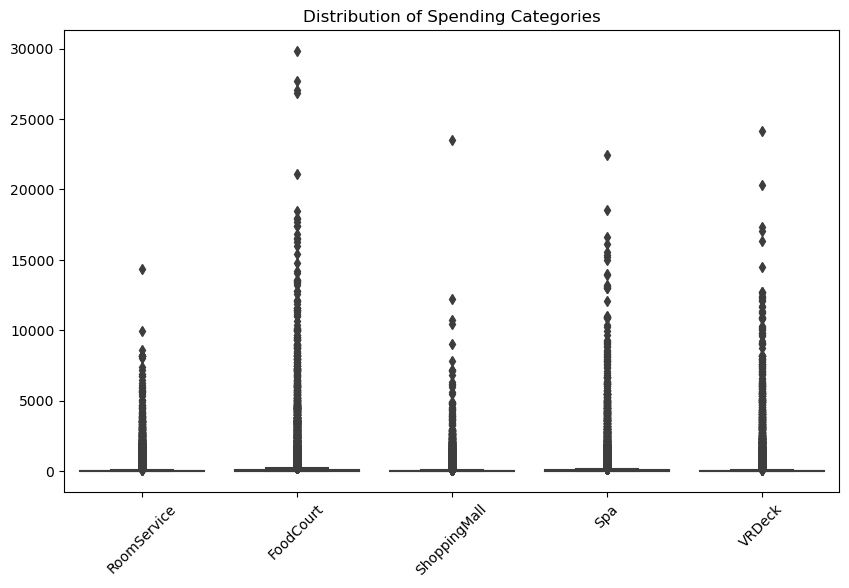

In [9]:
# 4. Box Plot untuk distribusi pengeluaran
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])
plt.title("Distribution of Spending Categories")
plt.xticks(rotation=45)
plt.show()

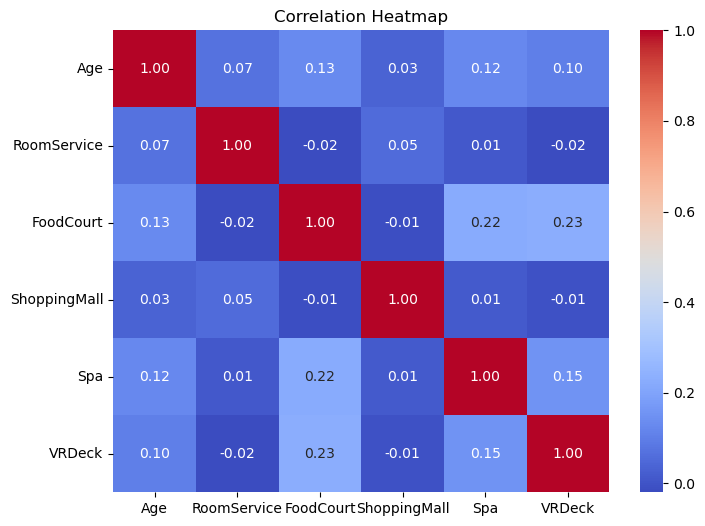

In [10]:
# 5. Heatmap untuk korelasi antara variabel numerik
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

<Figure size 800x600 with 0 Axes>

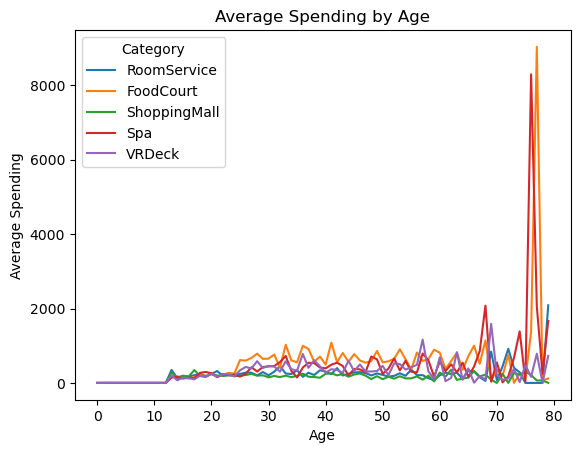

In [11]:
# 6. Line Chart untuk rata-rata pengeluaran berdasarkan umur
plt.figure(figsize=(8, 6))
df.groupby('Age')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean().plot()
plt.title("Average Spending by Age")
plt.xlabel("Age")
plt.ylabel("Average Spending")
plt.legend(title="Category")
plt.show()

## Seleksi Kolom

In [12]:
df.drop(columns="Name", inplace=True)
df.drop(columns="Cabin", inplace=True)

## Cleansing Data 

,missing_value,%
HomePlanet,201,2.31
CryoSleep,217,2.50
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11
VRDeck,188,2.16


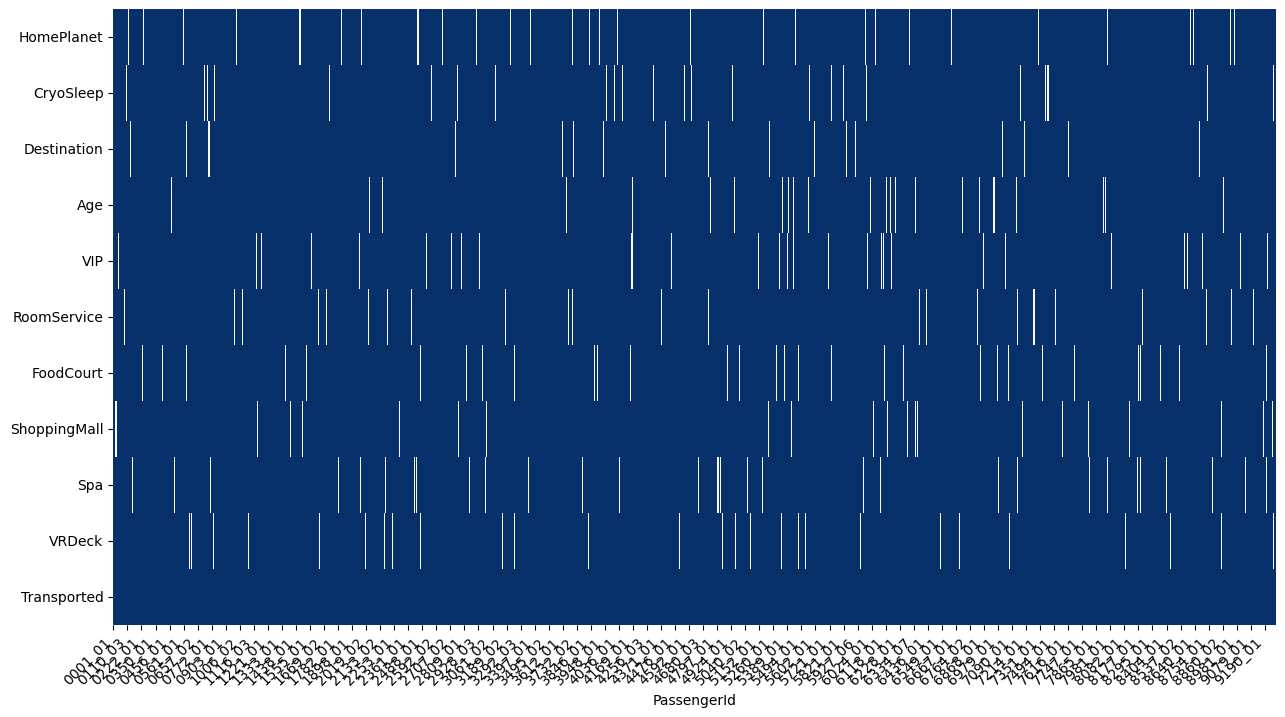

In [13]:
plot_missing_value(df, return_df=True)

In [14]:
df['HomePlanet'].replace("",np.nan, inplace=True)
df['CryoSleep'].replace("",np.nan, inplace=True)
df['Destination'].replace("",np.nan, inplace=True)
df['Age'].replace("",np.nan, inplace=True)
df['VIP'].replace("",np.nan, inplace=True)
df['RoomService'].replace("",np.nan, inplace=True)
df['FoodCourt'].replace("",np.nan, inplace=True)
df['ShoppingMall'].replace("",np.nan, inplace=True)
df['Spa'].replace("",np.nan, inplace=True)
df['VRDeck'].replace("",np.nan, inplace=True)

In [15]:
df['HomePlanet'].fillna(df['HomePlanet'].mode()[0], inplace=True)
df['CryoSleep'].fillna(df['CryoSleep'].mode()[0], inplace=True)
df['Destination'].fillna(df['Destination'].mode()[0], inplace=True)
df['VIP'].fillna(df['VIP'].mode()[0], inplace=True)

df['Age'].fillna(df['Age'].median(), inplace=True)
df['RoomService'].fillna(df['RoomService'].median(), inplace=True)
df['FoodCourt'].fillna(df['FoodCourt'].median(), inplace=True)
df['ShoppingMall'].fillna(df['ShoppingMall'].median(), inplace=True)
df['Spa'].fillna(df['Spa'].median(), inplace=True)
df['VRDeck'].fillna(df['VRDeck'].median(), inplace=True)

,missing_value,%
HomePlanet,0,0.0
CryoSleep,0,0.0
Destination,0,0.0
Age,0,0.0
VIP,0,0.0
RoomService,0,0.0
FoodCourt,0,0.0
ShoppingMall,0,0.0
Spa,0,0.0
VRDeck,0,0.0


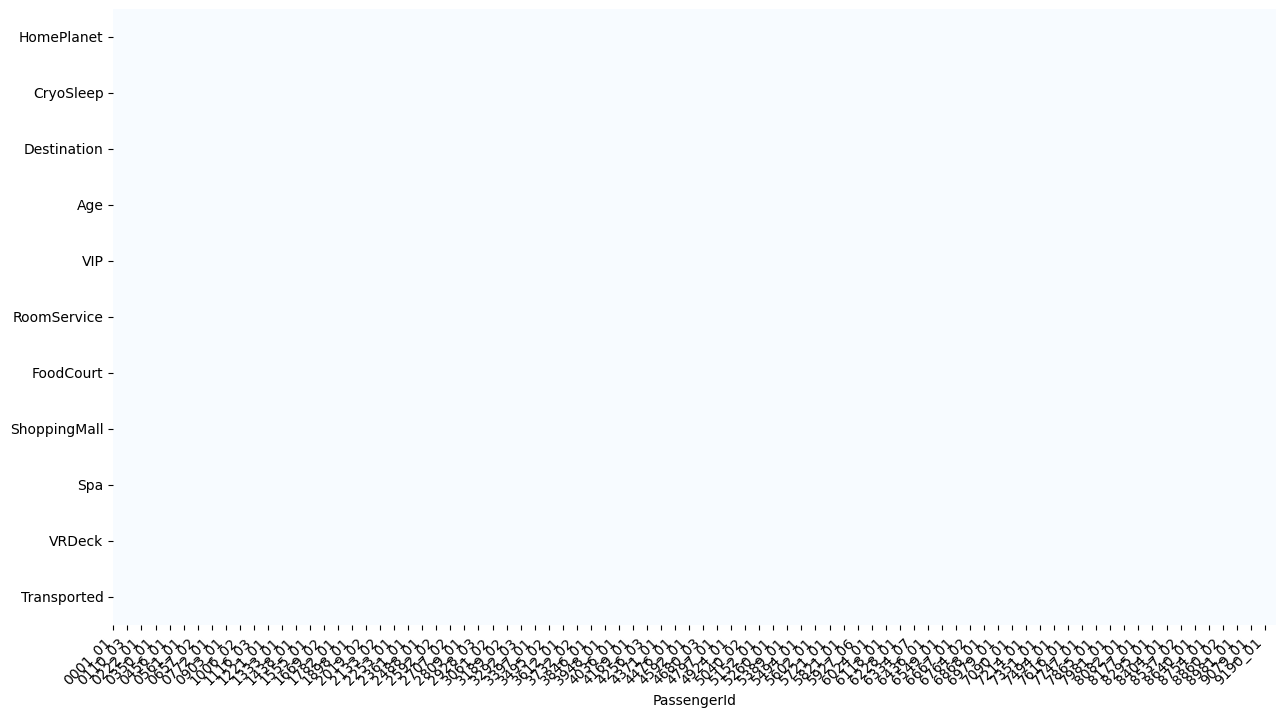

In [16]:
plot_missing_value(df, return_df=True)

In [17]:
df[df.duplicated()]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
PassengerId,,,,,,,,,,,
0108_03,Earth,False,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True
0133_01,Mars,True,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,True
0193_01,Mars,True,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,True
0220_02,Earth,False,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True
0220_03,Earth,True,TRAPPIST-1e,13.0,False,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...
9268_01,Earth,True,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,True
9270_01,Earth,True,55 Cancri e,33.0,False,0.0,0.0,0.0,0.0,0.0,True
9274_01,Earth,True,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,True


In [18]:
df.duplicated().value_counts()

False    5881
True     2812
dtype: int64

Tidak di-drop karena terlalu banyak, mungkin ada informasi yang penting di sana.

In [19]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
PassengerId,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True


In [20]:
bins = [0, 12, 19, 35, 60, df['Age'].max()]
labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']

df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

print(df[['Age', 'AgeGroup']].head())

              Age     AgeGroup
PassengerId                   
0001_01      39.0        Adult
0002_01      24.0  Young Adult
0003_01      58.0        Adult
0003_02      33.0  Young Adult
0004_01      16.0         Teen


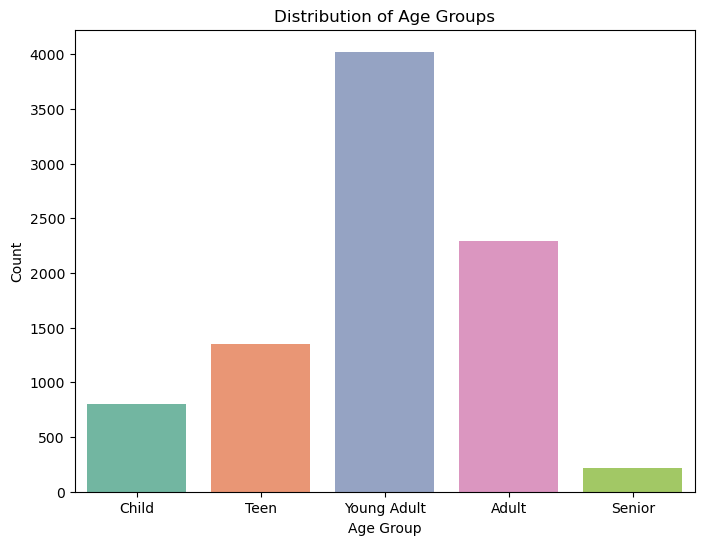

In [21]:
# 7. Bar Chart untuk AgeGroup
plt.figure(figsize=(8, 6))
sns.countplot(x=df['AgeGroup'], palette='Set2')
plt.title("Distribution of Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

## Target

In [22]:
df['Transported'].value_counts() 

True     4378
False    4315
Name: Transported, dtype: int64

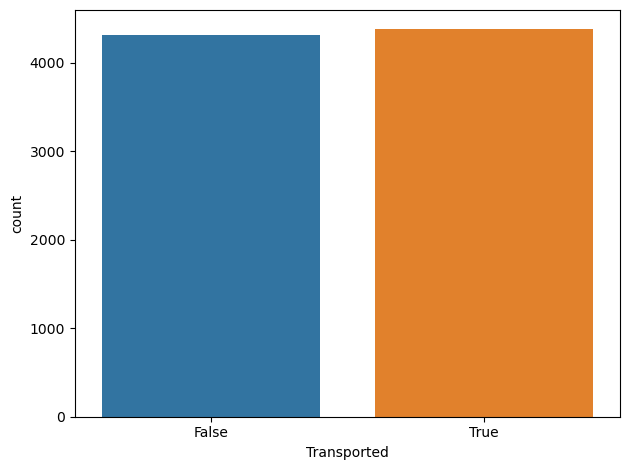

In [23]:
sns.countplot(data=df, x="Transported")
plt.tight_layout()

### Numeric vs Target 

/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


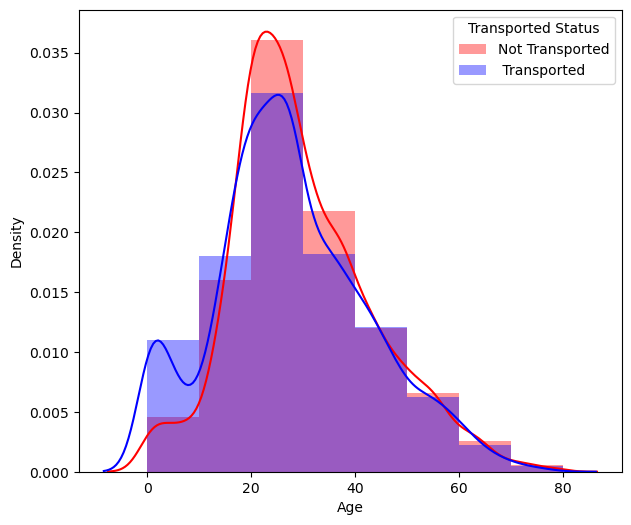

In [24]:
plt.figure(figsize=(7,6))
sns.distplot(df.Age[df.Transported == 0], bins=[0,10,20,30,40,50,60,70,80], color='r', label='Not Transported')
sns.distplot(df.Age[df.Transported == 1], bins=[0,10,20,30,40,50,60,70,80], color='b', label=' Transported')

plt.legend(title="Transported Status")
plt.show()

### Categoric vs Target 

/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

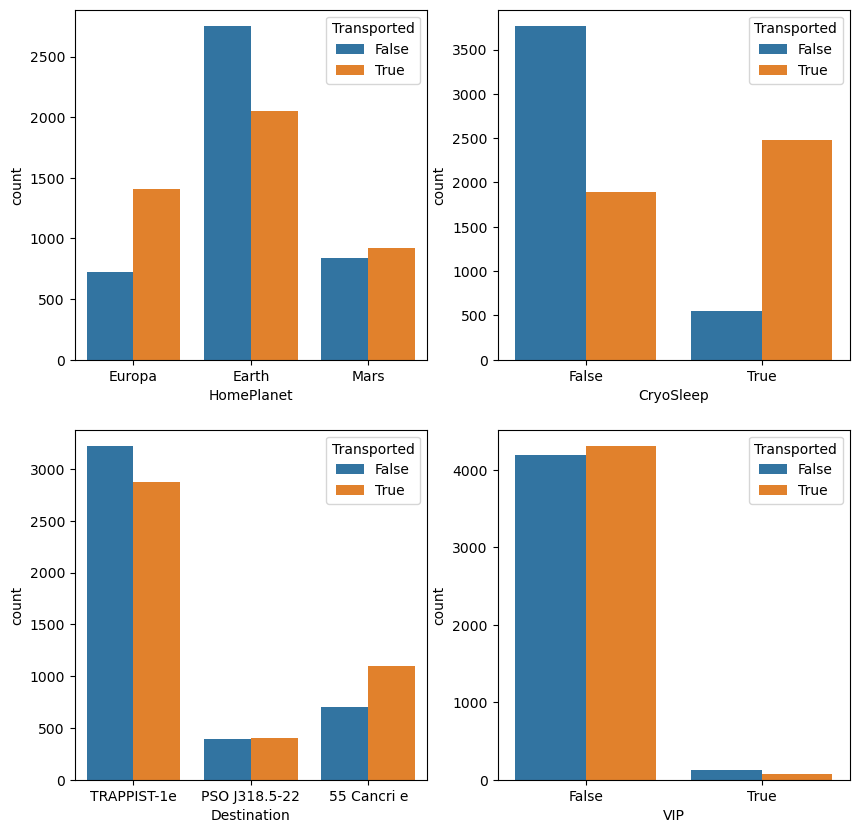

In [25]:
cat_var = ["HomePlanet","CryoSleep","Destination","VIP"]

fig, axes = plt.subplots(2,2, figsize=(10,10))
for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(cat, data=df, hue="Transported", ax=ax)

## Dataset Splitting

In [26]:
X = df.drop(columns="Transported")
y = df.Transported

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



((6954, 11), (1739, 11), (6954,), (1739,))

## Training 

In [27]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import grid_search_params as gsp

In [28]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [29]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination","VIP"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model_rf = RandomizedSearchCV(pipeline, rsp.rf_params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
model_rf.fit(X_train, y_train)

print(model_rf.best_params_)
print(model_rf.score(X_train, y_train), model_rf.best_score_, model_rf.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__max_depth': 42, 'algo__max_features': 0.3676836651209443, 'algo__min_samples_leaf': 15, 'algo__n_estimators': 155}
0.8206787460454414 0.7947943629565718 0.8021851638872916


In [30]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination","VIP","AgeGroup"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model_rf = RandomizedSearchCV(pipeline, rsp.rf_params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
model_rf.fit(X_train, y_train)

print(model_rf.best_params_)
print(model_rf.score(X_train, y_train), model_rf.best_score_, model_rf.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__max_depth': 41, 'algo__max_features': 0.24264070344564256, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 195}
0.8465631291343112 0.7953695714696577 0.79700977573318


# Phase 2: Feature Importance 

## Feature Importance 

In [31]:
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

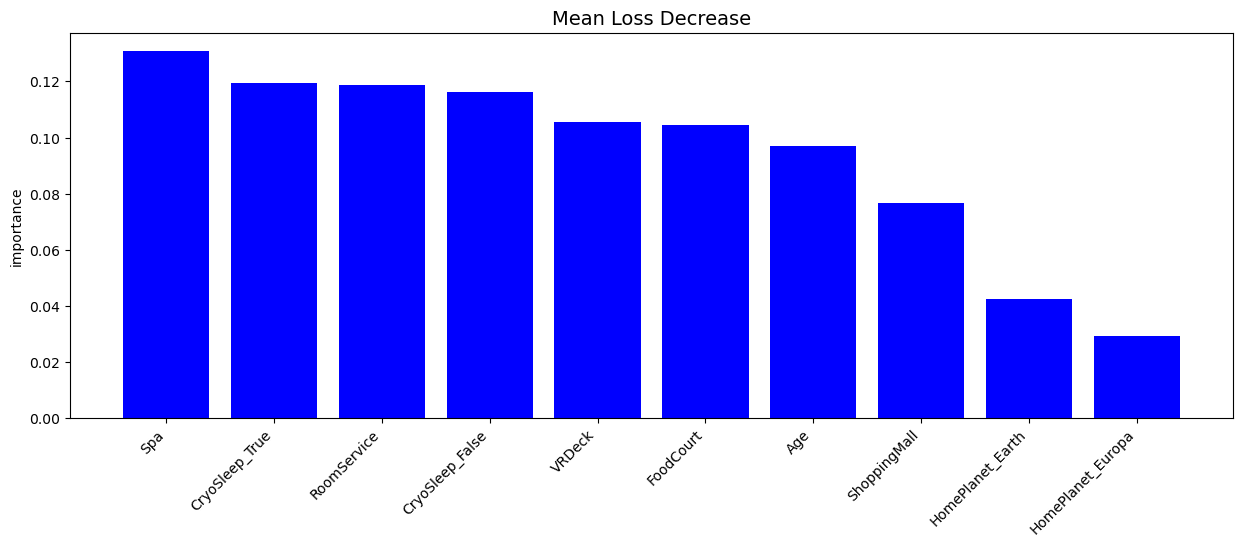

In [32]:
df_imp = mean_loss_decrease(X_train, model_rf, plot=True, topk=10)

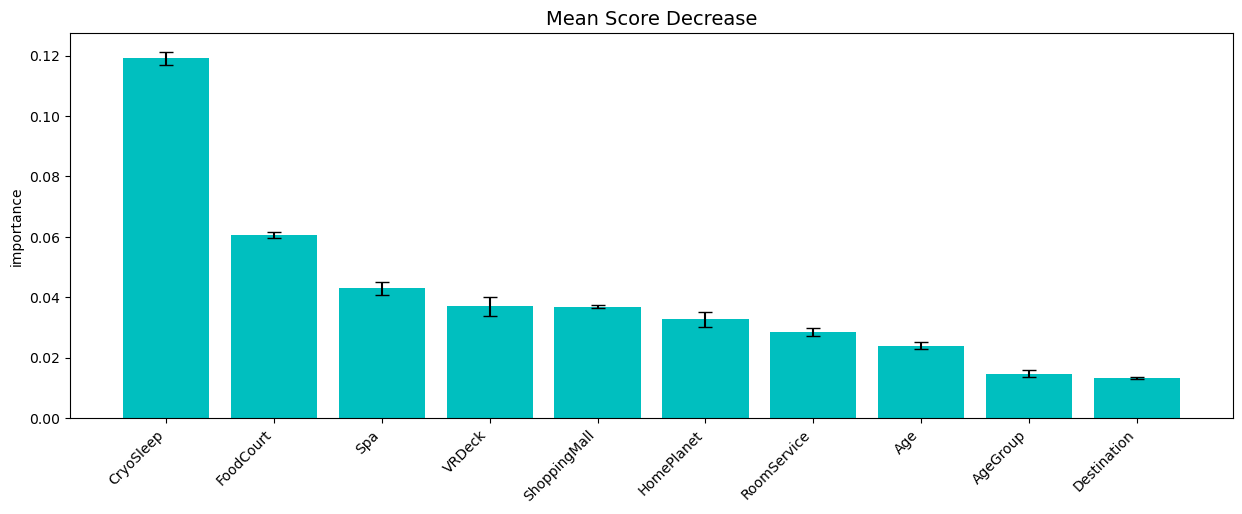

In [33]:
df_imp = mean_score_decrease(X_train, y_train, model_rf, plot=True, topk=10)

Buang VIP

# Phase 3: Setelah seleksi feature Vs Polynomialnya

In [34]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model_rf = RandomizedSearchCV(pipeline, rsp.rf_params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
model_rf.fit(X_train, y_train)

print(model_rf.best_params_)
print(model_rf.score(X_train, y_train), model_rf.best_score_, model_rf.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__max_depth': 79, 'algo__max_features': 0.8217425070488065, 'algo__min_samples_leaf': 17, 'algo__n_estimators': 101}
0.819672131147541 0.7940753523152143 0.7987349051178838


### Dengan Polynomial 

In [35]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model_rf = RandomizedSearchCV(pipeline, rsp.rf_poly_params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
model_rf.fit(X_train, y_train)

print(model_rf.best_params_)
print(model_rf.score(X_train, y_train), model_rf.best_score_, model_rf.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__max_depth': 47, 'algo__max_features': 0.8742404478964957, 'algo__min_samples_leaf': 18, 'algo__n_estimators': 137, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.8183779119930975 0.7943629565717573 0.7998849913743531


# Phase 4: Evaluasi Model

## Simple Plot 

In [36]:
from luwiji.evaluation import illustration, demo
from jcopml.plot import plot_classification_report, plot_confusion_matrix, plot_roc_curve, plot_pr_curve

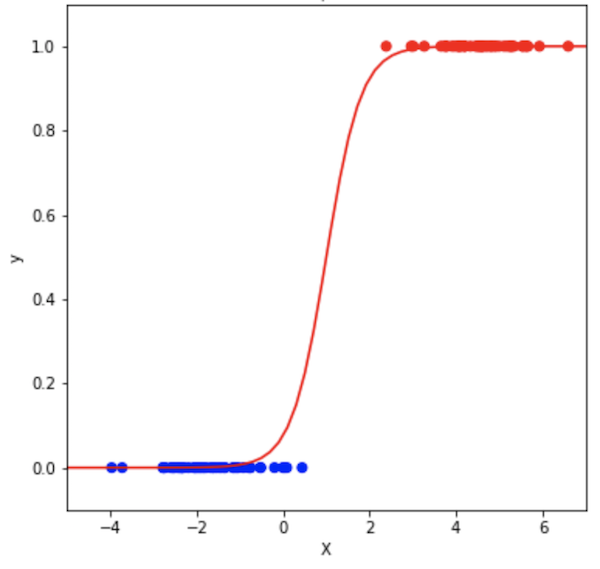

In [37]:
illustration.overlay_classification

## Classification Report 

In [38]:
plot_classification_report(X_train, y_train, X_test, y_test, model_rf, report=True)

Train report
              precision    recall  f1-score   support

       False       0.82      0.81      0.81      3452
        True       0.81      0.83      0.82      3502

    accuracy                           0.82      6954
   macro avg       0.82      0.82      0.82      6954
weighted avg       0.82      0.82      0.82      6954


Test report
              precision    recall  f1-score   support

       False       0.81      0.79      0.80       863
        True       0.79      0.81      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



## Confussion Matrix 

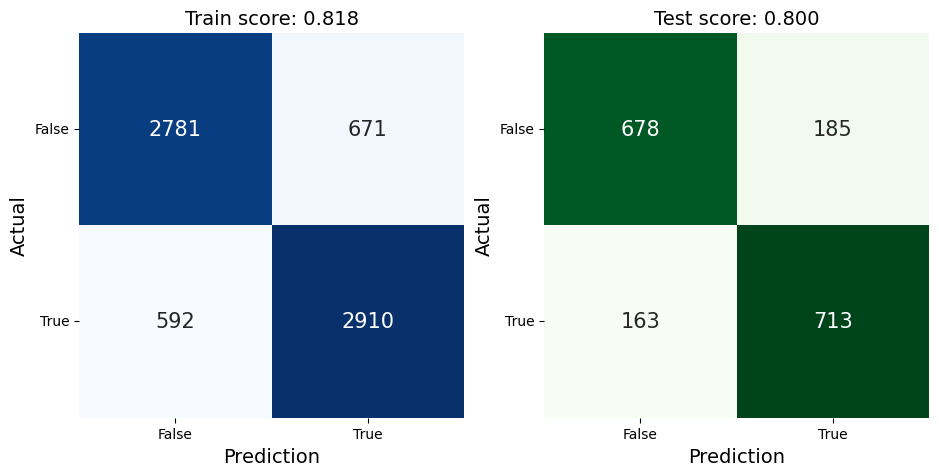

In [39]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model_rf)

## ROC-AUC 

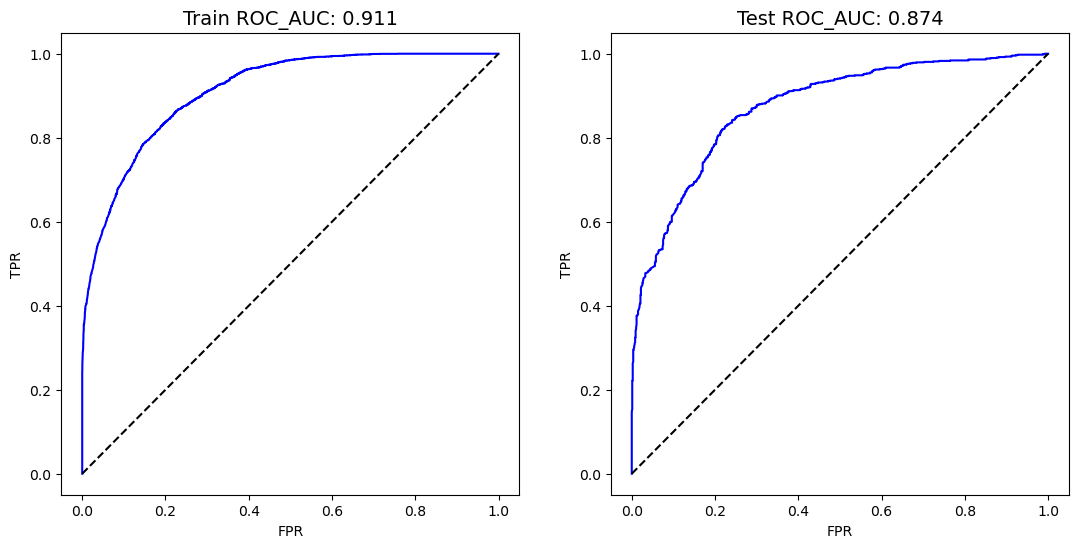

In [40]:
plot_roc_curve(X_train, y_train, X_test, y_test, model_rf)

# Phase 5: Improvement By Model 

## KNN

In [41]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

In [42]:
rsp.knn_params

{'algo__n_neighbors': Integer(low=1, high=40),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': Real(low=1, high=2, prior='uniform')}

In [43]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

model_knn = RandomizedSearchCV(pipeline, rsp.knn_params, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
model_knn.fit(X_train, y_train)

print(model_knn.best_params_)
print(model_knn.score(X_train, y_train), model_knn.best_score_, model_knn.score(X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'algo__n_neighbors': 23, 'algo__p': 1.7240068880823192, 'algo__weights': 'uniform'}
0.8060109289617486 0.7922063212119018 0.7878090856814262


### Dengan Polynomial

In [44]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='robust'), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

model_knn = RandomizedSearchCV(pipeline, rsp.knn_poly_params, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
model_knn.fit(X_train, y_train)

print(model_knn.best_params_)
print(model_knn.score(X_train, y_train), model_knn.best_score_, model_knn.score(X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'algo__n_neighbors': 38, 'algo__p': 1.0903828825152277, 'algo__weights': 'distance', 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.9319815933275812 0.7857356386637634 0.7849338700402531


## SVM 

In [45]:
# Import SVC
from sklearn.svm import SVC

In [46]:
rsp.svm_params

{'algo__gamma': Real(low=-3, high=3, prior='log-uniform'),
 'algo__C': Real(low=-3, high=3, prior='log-uniform')}

In [47]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model_svm = RandomizedSearchCV(pipeline, rsp.svm_params, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
model_svm.fit(X_train, y_train)

print(model_svm.best_params_)
print(model_svm.score(X_train, y_train), model_svm.best_score_, model_svm.score(X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site

{'algo__C': 0.0059281207668517456, 'algo__gamma': 0.014282478382134704}
0.7351164797238999 0.7228891796699234 0.7377803335250144


### Dengan Polynomial 

In [48]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', poly=2), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model_svm = RandomizedSearchCV(pipeline, rsp.svm_poly_params, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
model_svm.fit(X_train, y_train)

print(model_svm.best_params_)
print(model_svm.score(X_train, y_train), model_svm.best_score_, model_svm.score(X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site

{'algo__C': 7.82921262148761, 'algo__gamma': 0.010102806126023607, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.5345125107851596 0.6700878721896675 0.535365152386429


## Logistic Regression

In [49]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

In [50]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model_logreg = RandomizedSearchCV(pipeline, rsp.logreg_params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
model_logreg.fit(X_train, y_train)

print(model_logreg.best_params_)
print(model_logreg.score(X_train, y_train), model_logreg.best_score_, model_logreg.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

{'algo__C': 0.004762729862200735, 'algo__fit_intercept': False}
0.7940753523152143 0.7923497267759562 0.8010350776308223


### Dengan Polynomial 

In [51]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='robust'), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model_logreg = RandomizedSearchCV(pipeline, rsp.logreg_poly_params, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
model_logreg.fit(X_train, y_train)

print(model_logreg.best_params_)
print(model_logreg.score(X_train, y_train), model_logreg.best_score_, model_logreg.score(X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

{'algo__C': 0.0015541279683762505, 'algo__fit_intercept': False, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.7943629565717573 0.7924945047556491 0.7981598619896493


## XGBoost

In [52]:
# Import XGBClassifier
from xgboost import XGBClassifier

In [53]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model_xgb = RandomizedSearchCV(pipeline, rsp.xgb_params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
model_xgb.fit(X_train, y_train)

print(model_xgb.best_params_)
print(model_xgb.score(X_train, y_train), model_xgb.best_score_, model_xgb.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from p

[09:08:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'algo__colsample_bytree': 0.6340208753357018, 'algo__gamma': 10, 'algo__learning_rate': 0.30600470989056816, 'algo__max_depth': 7, 'algo__n_estimators': 133, 'algo__reg_alpha': 0.038584176967916425, 'algo__reg_lambda': 0.337871223477461, 'algo__subsample': 0.648369056285037}
0.8143514524014955 0.7901926948518838 0.7964347326049454


### Dengan Polynomial 

In [54]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]),
    ('categoric', cat_pipe(encoder='onehot'), ["HomePlanet","CryoSleep","Destination"]),
])

# Pipeline Definition
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model_xgb = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
model_xgb.fit(X_train, y_train)

print(model_xgb.best_params_)
print(model_xgb.score(X_train, y_train), model_xgb.best_score_, model_xgb.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mac/miniconda3/envs/jcopml/lib/python3.9/site-p

[09:09:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'algo__colsample_bytree': 0.47041660964287646, 'algo__gamma': 2, 'algo__learning_rate': 0.14423810687305164, 'algo__max_depth': 1, 'algo__n_estimators': 169, 'algo__reg_alpha': 0.4414469316860428, 'algo__reg_lambda': 0.0029374219770955503, 'algo__subsample': 0.4876118687661723, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': True}
0.7910555076215128 0.7910555076215129 0.7901092581943646


## Rekap Model

In [55]:
from sklearn.metrics import accuracy_score

models = [model_rf, model_knn, model_svm, model_logreg, model_xgb]
model_names = [ "Random Forest","KNN", "SVM", "Logistic Regression", "XGBoost"]
accuracy_scores = []

for model in models:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

df = pd.DataFrame({'Nama Model': model_names, 'Skor Akurasi': accuracy_scores})

print(df)


            Nama Model  Skor Akurasi
0        Random Forest      0.799885
1                  KNN      0.784934
2                  SVM      0.535365
3  Logistic Regression      0.798160
4              XGBoost      0.790109


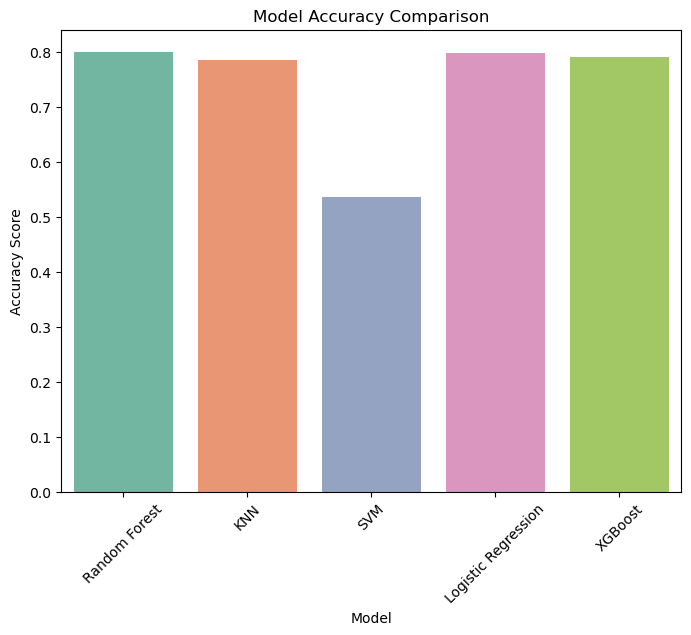

In [56]:
# 8. Bar Chart untuk Skor Akurasi Model
model_scores = pd.DataFrame({
    'Nama Model': ['Random Forest', 'KNN', 'SVM', 'Logistic Regression', 'XGBoost'],
    'Skor Akurasi': accuracy_scores
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Nama Model', y='Skor Akurasi', data=model_scores, palette='Set2')
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=45)
plt.show()

In [57]:
save_model(model_xgb.best_estimator_, "model_best.pkl")

Model is pickled as model/model_best.pkl
[09:08:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:08:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:08:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:08:4